In [ ]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1,
                    return_X_y=True)

X = X.values
y = y.astype(int).values

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
X = ((X / 255.) - .5) * 2

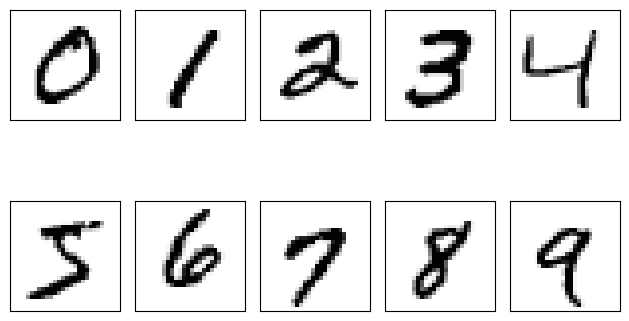

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5,
                       sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X[y == i][0].reshape(28, 28)
  ax[i].imshow(img, cmap="Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

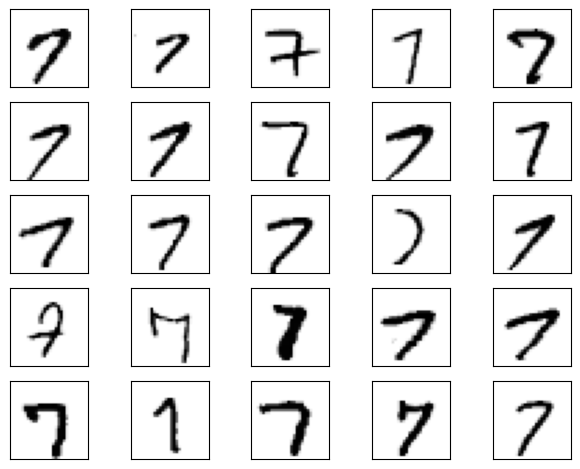

In [ ]:
fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex=True,
                       sharey=True)
ax = ax.flatten()
for i in range(25):
  img = X[y == 7][i].reshape(28, 28)
  ax[i].imshow(img, cmap="Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000,
    random_state=123, stratify=y_temp
)

In [ ]:
import numpy as np

def sigmoid(z):
  return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
  ary = np.zeros((y.shape[0], num_labels))
  for i, val in enumerate(y):
    ary[i, val] = 1

  return ary

In [ ]:
class NeuralNetMLP:
  def __init__(self, num_features, num_hidden,
               num_classes, random_seed=123):
    super().__init__()

    import numpy as np

    self.num_classes = num_classes

    #hidden
    rng = np.random.RandomState(random_seed)

    self.weight_h = rng.normal(
        loc=.0, scale=.1, size=(num_hidden, num_features))
    self.bias_h = np.zeros(num_hidden)

    #output
    self.weight_out = rng.normal(
        loc=.0, scale=.1, size=(num_classes, num_hidden))
    self.bias_out = np.zeros(num_classes)

  def forward(self, X):

    z_h = np.dot(X, self.weight_h.T) + self.bias_h
    a_h = sigmoid(z_h)

    z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
    a_out = sigmoid(z_out)

    return a_h, a_out

  def backward(self, x, a_h, a_out, y):

    y_onehot = int_to_onehot(y, self.num_classes)

    # Part 1: dLoss/dOutWeights
    ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
    ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
    ## for convenient re-use

    # input/output dim: [n_examples, n_classes]
    d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

    # input/output dim: [n_examples, n_classes]
    d_a_out__d_z_out = a_out*(1. - a_out) #sigmoid derivative

    # output dim: [n_examples, n_classes]
    delta_out = d_loss__d_a_out * d_a_out__d_z_out

    # output dim: [n_examples, n_classses]
    d_z_out__dw_out = a_h

    # input dim: [n_classes, n_examples]
    # dot [n_examples, n_hidden]
    # output dim: [n_classes, n_hidden]
    d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
    d_loss__db_out = np.sum(delta_out, axis=0)


    #################################
    # Part 2: dLoss/dHiddenWeights
    ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet
    # * dHiddenNet/dWeight

    # [n_classes, n_hidden]
    d_z_out__a_h = self.weight_out

    # output dim: [n_examples, n_hidden]
    d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

    # [n_examples, n_hidden]
    d_a_h__d_z_h = a_h * (1. - a_h)

    # [n_examples, n_features]
    d_z_h__d_w_h = x

    # output dim: [n_hidden, n_features]
    d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T,
                           d_z_h__d_w_h)
    d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

    return (d_loss__dw_out, d_loss__db_out,
            d_loss__d_w_h, d_loss__d_b_h)

In [ ]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [ ]:
import numpy as np
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)
  for start_idx in range(0, indices.shape[0] - minibatch_size
                         + 1, minibatch_size):
    batch_idx = indices[start_idx:start_idx + minibatch_size]
    yield X[batch_idx], y[batch_idx]

for i in range(num_epochs):
  minibatch_gen = minibatch_generator(
      X_train, y_train, minibatch_size)
  for X_train_mini, y_train_mini in minibatch_gen:
    break
  break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [ ]:
def mse_loss(targets, probas, num_labels=10):
  onehot_targets = int_to_onehot(
      targets, num_labels=num_labels)
  return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
  return np.mean(predicted_labels == targets)

In [ ]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f"Initial validation MSE: {mse:.1f}")

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f"Initial validation accuracy: {acc*100:.1f}")

Initial validation MSE: 0.3
Initial validation accuracy: 9.4


In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=10,
                        minibatch_size=100):
  mse, correct_pred, num_examples = .0, 0, 0
  minibatch_gen = minibatch_generator(X, y, minibatch_size)
  for i, (features, targets) in enumerate(minibatch_gen):
    _, probas = nnet.forward(features)
    predicted_labels = np.argmax(probas, axis=1)
    onehot_targets = int_to_onehot(
        targets, num_labels=num_labels
    )
    loss = np.mean((onehot_targets - probas)**2)
    correct_pred += (predicted_labels == targets).sum()
    num_examples += targets.shape[0]
    mse += loss
  mese = mse / i
  acc = correct_pred / num_examples
  return mse, acc

In [ ]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f"Initial valid MSE: {mse:.1f}")
print(f"Initial valid accuracy: {acc*100:.1f}")

Initial valid MSE: 13.5
Initial valid accuracy: 9.4


In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=.1):
  epoch_loss = []
  epoch_train_acc = []
  epoch_valid_acc = []

  for e in range(num_epochs):
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
      a_h, a_out = model.forward(X_train_mini)

      d_loss__d_w_out, d_loss__d_b_out, \
      d_loss__d_w_h, d_loss__d_b_h = model.backward(
          X_train_mini, a_h, a_out, y_train_mini)

      model.weight_h -= learning_rate * d_loss__d_w_h
      model.bias_h -= learning_rate * d_loss__d_b_h
      model.weight_out -= learning_rate * d_loss__d_w_out
      model.bias_out -= learning_rate * d_loss__d_b_out

    train_mse, train_acc = compute_mse_and_acc(
        model, X_train, y_train)
    valid_mse, valid_acc = compute_mse_and_acc(
        model, X_valid, y_valid)
    train_acc, valid_acc = train_acc*100, valid_acc*100
    epoch_train_acc.append(train_acc)
    epoch_valid_acc.append(valid_acc)
    epoch_loss.append(train_mse)
    print(f"Epoch: {e+1:03d}/{num_epochs:03d}"
          f"| Train MSE: {train_mse:.2f}"
          f"| Train Acc: {train_acc:.2f}%"
          f"| Valid Acc: {valid_acc:.2f}%")
  return epoch_loss, epoch_train_acc, epoch_valid_acc

In [ ]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=25, learning_rate=.1)

Epoch: 001/025| Train MSE: 7.57| Train Acc: 92.26%| Valid Acc: 92.00%
Epoch: 002/025| Train MSE: 7.39| Train Acc: 92.39%| Valid Acc: 92.20%
Epoch: 003/025| Train MSE: 7.17| Train Acc: 92.65%| Valid Acc: 92.22%
Epoch: 004/025| Train MSE: 7.00| Train Acc: 92.86%| Valid Acc: 92.54%
Epoch: 005/025| Train MSE: 6.81| Train Acc: 93.04%| Valid Acc: 92.68%
Epoch: 006/025| Train MSE: 6.71| Train Acc: 93.14%| Valid Acc: 92.78%
Epoch: 007/025| Train MSE: 6.55| Train Acc: 93.30%| Valid Acc: 92.86%
Epoch: 008/025| Train MSE: 6.40| Train Acc: 93.43%| Valid Acc: 93.20%
Epoch: 009/025| Train MSE: 6.28| Train Acc: 93.47%| Valid Acc: 93.28%
Epoch: 010/025| Train MSE: 6.16| Train Acc: 93.63%| Valid Acc: 93.34%
Epoch: 011/025| Train MSE: 6.06| Train Acc: 93.77%| Valid Acc: 93.38%
Epoch: 012/025| Train MSE: 5.96| Train Acc: 93.83%| Valid Acc: 93.40%
Epoch: 013/025| Train MSE: 5.88| Train Acc: 93.89%| Valid Acc: 93.58%
Epoch: 014/025| Train MSE: 5.79| Train Acc: 94.05%| Valid Acc: 93.84%
Epoch: 015/025| Trai

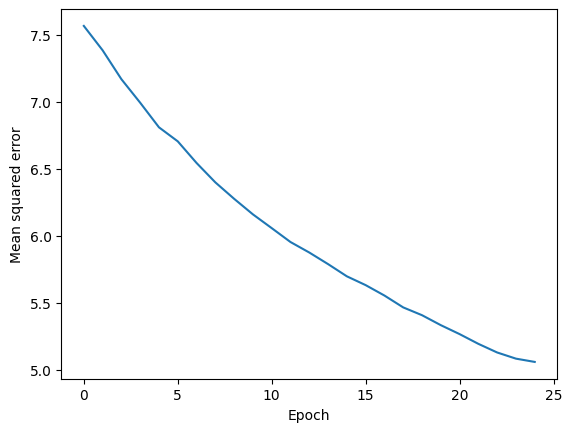

In [ ]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel("Mean squared error")
plt.xlabel("Epoch")
plt.show()

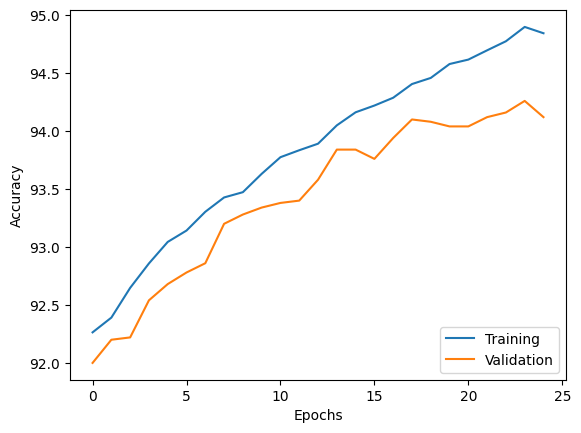

In [ ]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label="Training")
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label="Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.show()

In [ ]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f"Test accuracy: {test_acc*100:.2f}")

Test accuracy: 93.96


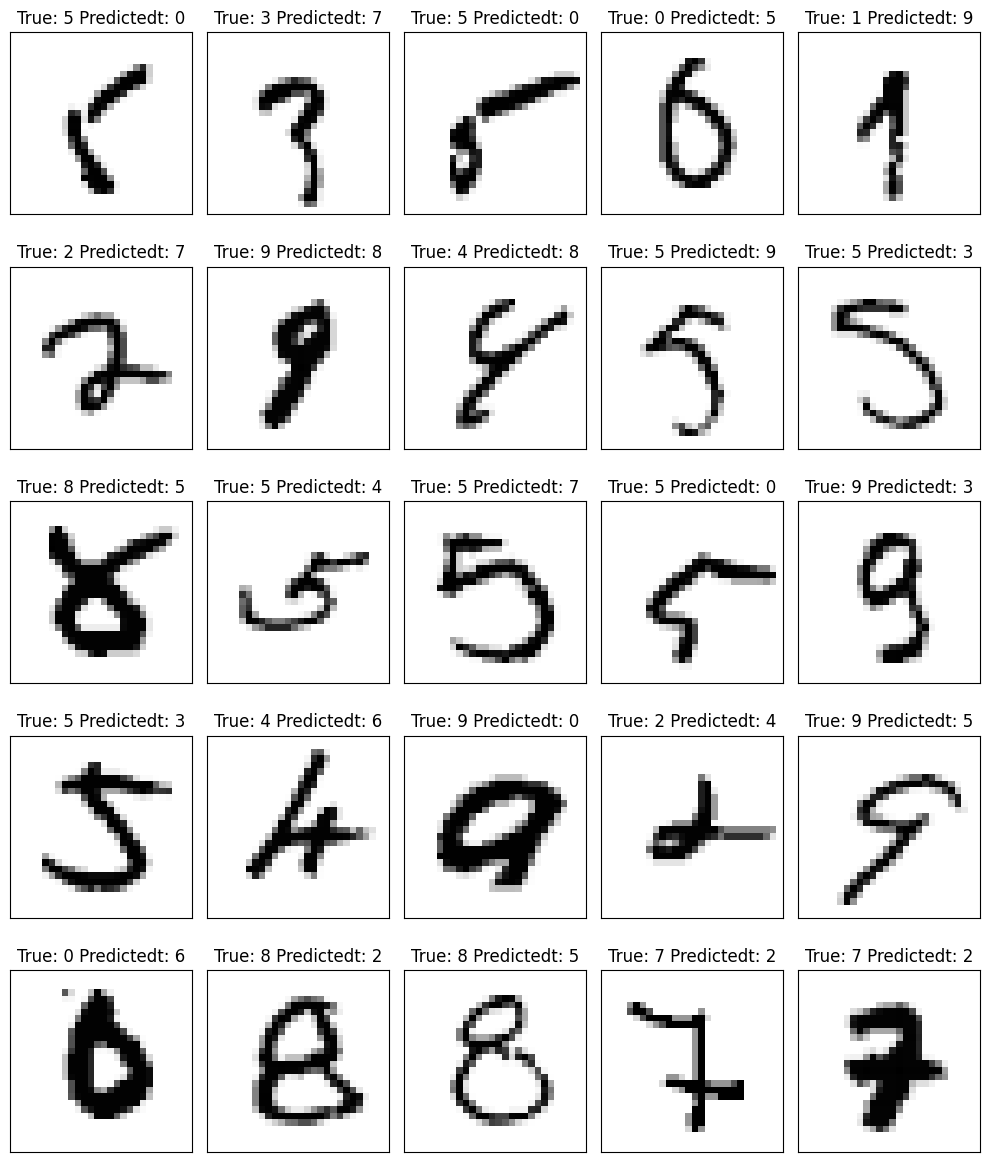

In [ ]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(10, 12))
ax = ax.flatten()
for i in range(25):
  img = misclassified_images[i].reshape(28, 28)
  ax[i].imshow(img, cmap="Greys", interpolation="nearest")
  ax[i].set_title(f"True: {correct_labels[i]}"
                  f" Predictedt: {misclassified_labels[i]}")
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()